In [2]:
# Main modules 
import torch
from torch import Generator
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms.functional import to_pil_image
import pandas as pd
import matplotlib.pyplot as plt

# Custom modules
from frogfunctions import Model 
from frogfunctions import setup_seed, train_loop, test_loop, train_model, plot_probabilities

In [3]:
# Dataframe output format
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# Set device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
PATH = '../saved_models/model'
model = Model(num_classes=7).to(device)
model.load_state_dict(torch.load(PATH))
model.eval();

In [5]:
sal_dir = "../test_data/class_images/"

In [6]:
import torch
from torch import manual_seed as torch_manual_seed
from torch.cuda import manual_seed_all
from torch.backends import cudnn
import torch.nn.functional as nnf
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
from timeit import default_timer as timer

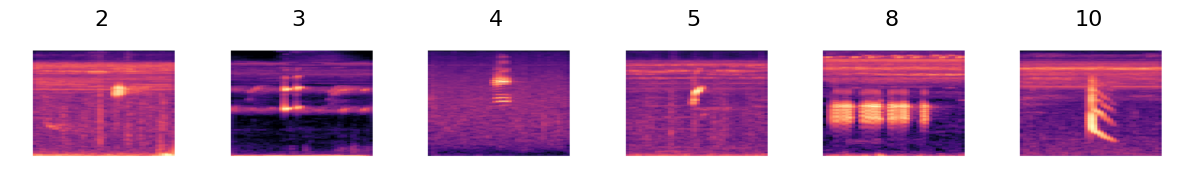

In [28]:
from matplotlib import pyplot as plt
from torchvision import transforms
from PIL import Image
# model expectation is 224x224 3-color image
transform = transforms.Compose([
#  transforms.Resize((224, 224)),
#  transforms.Resize(256),
#  transforms.CenterCrop(224), #crop the given tensor image at the center
 transforms.ToTensor()
])
# ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

# img_transformed = transform(img)
# img_normalized = transform_normalize(img_transformed)
# img_normalized = img_normalized.unsqueeze(0)


# Image titles
image_titles = ['2', '3', '4', '5', '8', '10'] #
# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
labels = [1, 2, 3, 4, 5, 6] #
images=[Image.open("../test_data/class_images/"+i+'.png').convert('RGB') for i in image_titles]

# Rendering
f, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [29]:
model.convolutional[14]

Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [30]:
from matplotlib.colors import LinearSegmentedColormap
import torch.nn as nn

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)


import numpy as np
from torchvision.transforms.functional import to_tensor
from captum.attr import Saliency, visualization as viz, LayerGradientXActivation, LayerAttribution, LayerActivation

saliency = Saliency(model)

def run_image(img_pil, target):
#     print(f'img_normalized.shape={img_normalized.shape}')

    img_transformed = transform(img_pil)
    img_normalized = transform_normalize(img_transformed)
    img_normalized = img_normalized.to(device)
    img_normalized = img_normalized.unsqueeze(0)
    # move the input and model to GPU for speed if available

    output = model(img_normalized)
        
    print('before first grad')
    grads = saliency.attribute(img_normalized, target=target)
    print('after first grad')
    grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))
    print('after second grad')
    
    #model, model.convolutional[14]
    
    layer_ga = LayerGradientXActivation(model, model.convolutional[14]) #
    # Computes layer activation x gradient for class 3.
    # attribution size matches layer output, Nx12x32x32
    attribution = layer_ga.attribute(img_normalized, target)
    print(f'attribution.shape={attribution.shape}')
    upsamp_attr_lgc = LayerAttribution.interpolate(attribution, img_normalized.shape[2:])
    viz.visualize_image_attr_multiple(np.transpose(upsamp_attr_lgc.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          img_transformed.permute(1,2,0).numpy(),
                                          ["original_image", "blended_heat_map"],
                                          ["all", "positive"],
                                          cmap=default_cmap,
                                          show_colorbar=True)

before first grad
after first grad
after second grad
attribution.shape=torch.Size([1, 256, 29, 39])


ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

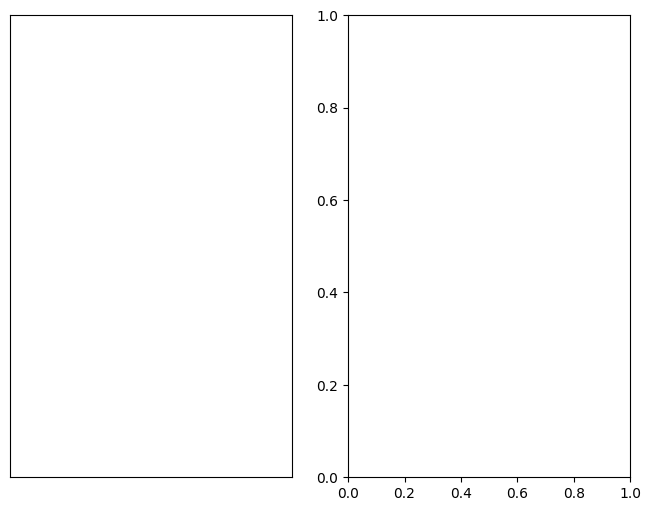

In [31]:
for i, (img_pil, label) in enumerate(zip(images, labels)):
    run_image(img_pil, label)